<a href="https://colab.research.google.com/github/Tensor10/GEEMAP/blob/main/FeatureDesign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ISPRS Tutorial on Satellite Time Series

Authors:

[Dr. Marc Russwurm](https://www.marcrusswurm.com) [EPFL-ECEO](https://www.epfl.ch/labs/eceo/)
Prof. Charlotte Pelletier IRISA-Obelix

main tutorial page
https://dl4sits.github.io/isprs2022/tutorial/

<img src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by.png" width=100px>

## Part 1: Feature Engineering

<img src="https://i.ibb.co/YdWhzKH/Notebook1.png" width=100%>

# 1 Setup



## Installation and import of depenencies

Run the next cell to install and import python packages 

In [1]:
#@title
!pip install -q geopandas rasterio

# plotting
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

plt.rc("axes.spines", top=False, right=False)

     |████████████████████████████████| 1.1 MB 28.6 MB/s 
     |████████████████████████████████| 20.9 MB 1.2 MB/s 
     |████████████████████████████████| 7.8 MB 75.0 MB/s 
     |████████████████████████████████| 16.6 MB 89.2 MB/s 


Download images via Google Earth Engine (requires your GEE account and authentification)

In [ ]:
#@title

from tqdm.notebook import tqdm # a progress bar

if False: # set to True if you want to experiment downloading different data
    
  !pip install -q earthengine-api, geetools

  import ee
  import geetools

  ee.Initialize()

  kermaux_bbox = ee.Geometry.Polygon(
          [[[-2.9457719012612382, 47.993372564749684],
            [-2.9457719012612382, 47.9697021389503],
            [-2.9004532977456132, 47.9697021389503],
            [-2.9004532977456132, 47.993372564749684]]], proj="epsg:4326", geodesic=False)

  s2 = ee.ImageCollection("COPERNICUS/S2_SR");

  collection = s2.filterBounds(kermaux_bbox).filterDate("2018-01-01","2018-12-31")

  tasks = geetools.batch.Export.imagecollection.toDrive(
              collection=collection,
              folder="kermaux2018",
              region=kermaux_bbox,
              scale=10,
              verbose=True,
              maxPixels=int(1e13)
          )
else:
  print("please download data via the next cell. This code is for-your-information (FYI) if you want to get data from other areas")

# this code takes the downloaded files from the google drive and stacks them 
# to the variables used in this notebook
if False:
  root = "/content/drive/MyDrive/kermaux2018"

  tifs = os.listdir(root)
  images_df = pd.DataFrame(tifs, columns=["filename"])
  images_df["date"] = images_df.filename.apply(lambda name: name[:8])
  images_df = images_df.drop_duplicates("date").sort_values(by="date")

  timeseries, dates = [], []
  for tif in tqdm(images_df.filename, desc="stacking tif images"):
    with rio.open(os.path.join(root,tif), "r") as src:
      img = src.read()
      transform = src.transform
      crs = src.crs
      if img.shape[0] == 23:
        timeseries.append(img)
        dates.append(datetime.strptime(tif[:8],"%Y%m%d"))

  timeseries = np.stack(timeseries)

  np.savez("kermaux2018.npz", 
         timeseries=timeseries,
         dates=dates,
         transform=transform,
         crs=str(crs))

please download data via the next cell. This code is for-your-information (FYI) if you want to get data from other areas


## Download Image Time Series for this Tutorial

In [2]:
# download shapefiles Amazon AWS bucket (suppress output)
!wget -nc https://breizhcrops.s3.eu-central-1.amazonaws.com/2018/shp/kermaux.tar.gz 
!wget -nc wget https://breizhcrops.s3.eu-central-1.amazonaws.com/classmapping.csv
!tar -xvf kermaux.tar.gz

# time series data
!wget -nc https://breizhcrops.s3.eu-central-1.amazonaws.com/kermaux2018.npz

--2022-12-25 23:29:01--  https://breizhcrops.s3.eu-central-1.amazonaws.com/2018/shp/kermaux.tar.gz
Resolving breizhcrops.s3.eu-central-1.amazonaws.com (breizhcrops.s3.eu-central-1.amazonaws.com)... 52.219.75.112
Connecting to breizhcrops.s3.eu-central-1.amazonaws.com (breizhcrops.s3.eu-central-1.amazonaws.com)|52.219.75.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71680 (70K) [application/x-tar]
Saving to: ‘kermaux.tar.gz’

kermaux.tar.gz      100%[===================>]  70.00K   395KB/s    in 0.2s    

2022-12-25 23:29:01 (395 KB/s) - ‘kermaux.tar.gz’ saved [71680/71680]

--2022-12-25 23:29:02--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2022-12-25 23:29:02--  https://breizhcrops.s3.eu-central-1.amazonaws.com/classmapping.csv
Resolving breizhcrops.s3.eu-central-1.amazonaws.com (breizhcrops.s3.eu-central-1.amazonaws.com)... 52.219.75.112
Connecting to breizhcrops.s3.eu-central-

# 2 Exploration of the data

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np

from datetime import datetime


In [4]:
# load timeseries from stored zipped numpy file:

npzfile = np.load("kermaux2018.npz", allow_pickle=True)
timeseries = npzfile["timeseries"]
dates = npzfile["dates"]
transform = npzfile["transform"]
crs = npzfile["crs"]


## 2.1 Fields and crop type labels

### Crop parcels

,ID_PARCEL,SURF_PARC,CODE_CULTU,CODE_GROUP,CULTURE_D1,CULTURE_D2,geometry,id,classname,code,color,ID
0,6025182,4.81,BTH,1,DVN,DVS,"POLYGON ((-2.91859 47.98955, -2.91890 47.98980...",1,wheat,BTH,#e41a1c,0
1,6097821,9.82,BTH,1,DPH,DRD,"POLYGON ((-2.91462 47.97637, -2.91542 47.97662...",1,wheat,BTH,#e41a1c,1
2,6097827,4.15,BTH,1,DPH,DRD,"POLYGON ((-2.93001 47.98207, -2.92670 47.98235...",1,wheat,BTH,#e41a1c,2
3,6097919,3.00,BTH,1,DPH,DRD,"POLYGON ((-2.92173 47.98304, -2.92224 47.98292...",1,wheat,BTH,#e41a1c,3
4,5980906,5.86,BTH,1,DRD,DMD,"POLYGON ((-2.91668 47.97996, -2.91649 47.97996...",1,wheat,BTH,#e41a1c,4
...,...,...,...,...,...,...,...,...,...,...,...,...
61,None,NaN,CZH,None,None,None,"POLYGON ((-2.94238 47.97496, -2.94238 47.97495...",2,rapeseed,CZH,#ff7f00,61
62,5985407,3.93,PTR,19,None,None,"POLYGON ((-2.91889 47.97291, -2.91894 47.97295...",8,temporary meadows,PTR,#007480,62
63,None,NaN,PTR,None,None,None,"POLYGON ((-2.90649 47.98958, -2.90654 47.99001...",8,temporary meadows,PTR,#007480,63
64,13075287,4.97,RGA,19,None,None,"POLYGON ((-2.94044 47.97243, -2.94051 47.97242...",8,temporary meadows,RGA,#007480,64


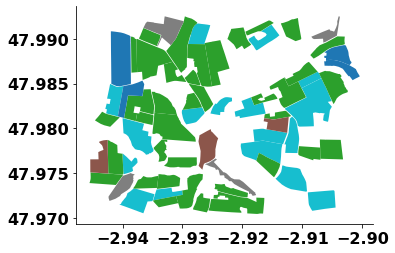

In [5]:
colors = ['#e41a1c','#377eb8','#007480','#984ea3','#ff7f00']
classname = ['wheat', 'corn', 'temporary meadows', 'barley', 'rapeseed']

# load shape file (previously downloaded)
gdf = gpd.read_file("kermaux.shp")

# load the mapping from id to classname
mapping = pd.read_csv("classmapping.csv", index_col=0)

# add names to ids
gdf = pd.merge(gdf, mapping, how='inner', left_on="CODE_CULTU", right_on="code")

# add colors to the dataframe
colors = pd.DataFrame([colors, classname], index=["color","classname"]).T
gdf = pd.merge(gdf, colors, how='inner', left_on="classname", right_on="classname")
gdf["ID"] = gdf.reset_index()["index"]

gdf.plot(column="classname")
gdf

### Kermaux area field locations

In [6]:
# interactive map
import folium
from folium.features import DivIcon

map = folium.Map(location=[47.9959, -2.90391], zoom_start=15)

def style_function(x):
  return {'fillColor': x["properties"]["color"], 
          "weight":0,
          "fill-opacity":1}

folium.GeoJson(data=gdf.to_json(), style_function=style_function).add_to(map)

# add annotations
for idx, row in gdf.iterrows():
  folium.Marker(
      [row.geometry.centroid.y, row.geometry.centroid.x],
      icon=DivIcon(
        icon_size=(1,1),
        icon_anchor=(20,0),
        html=f'<div style="font-size: 12pt">{row.classname}</div>',
        )
  ).add_to(map)

# plot map
map

### Vector data and raster data

<img src="https://breizhcrops.s3.eu-central-1.amazonaws.com/isprstutorial2022/rasterize_example.png" width=200px>

(-0.5, 339.5, 263.5, -0.5)

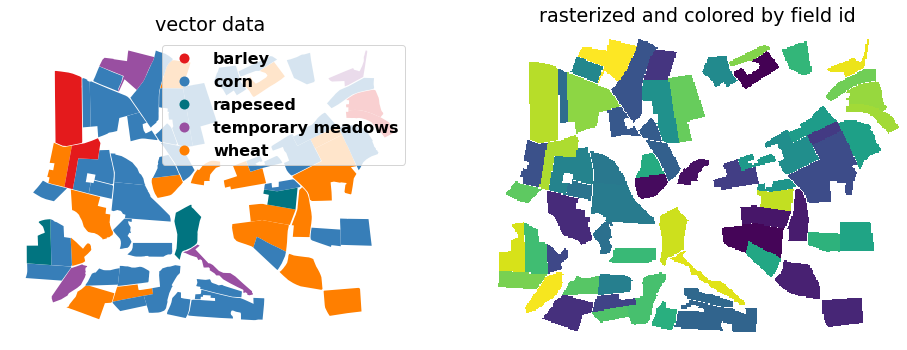

In [7]:
# vector and raster data
import rasterio as rio
from rasterio.features import rasterize

transform = rio.transform.Affine.from_gdal(504040.0, 10.0, 0.0, 5315570.0, 0.0, -10.0)
crs = "EPSG:32630"

croptype_rasterized = rasterize(zip(gdf.to_crs(crs).geometry, gdf.id), out_shape=(timeseries.shape[2],timeseries.shape[3]), transform=transform, fill=np.nan)
id_rasterized = rasterize(zip(gdf.to_crs(crs).geometry, gdf.ID), out_shape=(timeseries.shape[2],timeseries.shape[3]), transform=transform, fill=np.nan)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("name", colors.color)

fig, axs = plt.subplots(1,2,figsize=(8*2,8))

ax = axs[0]
gdf.plot(column="classname", cmap=cmap, ax=ax, legend=True)
ax.set_title("vector data")
ax.axis("off")

ax = axs[1]
ax.set_title("rasterized and colored by field id")
im = ax.imshow(id_rasterized, interpolation="none")
ax.axis("off")


# 2.2 Satellite data

### Sentinel-2 Satellite


* 2-Satellite constellation
* 10-60 m pixel size
* 13 spectral bands
* 2-5 days revisit period (global coverage)

<img src="https://www.esa.int/var/esa/storage/images/esa_multimedia/images/2008/11/sentinel-2/9773238-3-eng-GB/Sentinel-2_pillars.jpg" width=400px>

### Spectral bands

https://www.usgs.gov/centers/eros/science/usgs-eros-archive-sentinel-2-comparison-sentinel-2-and-landsat

<img src="https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/styles/full_width/public/thumbnails/image/dmidS2LS7Comparison.png?itok=BQqyWSGJ" width=100%>

In [8]:
bands = ["B1",  # ultra-violett
         "B2",  # blue
         "B3",  # green
         "B4",  # red
         "B5",  # near-infrared
         "B6",  # near-infrared
         "B7",  # near-infrared
         "B8",  # near-infrared
         "B8A", # near-infrared 
         "B9",  # atmosphere
         "B11", # short-wave infrared
         "B12", # short-wave infrared
         "AOT", 
         "WVP", 
         "SCL", 
         "TCI_R", 
         "TCI_G", 
         "TCI_B", 
         "MSK_CLDPRB", # cloud probability 
         "MSK_SNWPRB", 
         "QA10", 
         "QA20", 
         "QA60" # quality flag (will be used for cloud filtering later)
         ]

### Time series data dimensions

Timeseries

<img src="https://breizhcrops.s3.eu-central-1.amazonaws.com/isprstutorial2022/Time.png" width=200px>

In [9]:
print(f"T x D x H x W: {timeseries.shape}")

T x D x H x W: (138, 23, 264, 340)



Image of height $H$, width $W$ and spectral bands $D$

<img src="https://breizhcrops.s3.eu-central-1.amazonaws.com/isprstutorial2022/Bands.png" width=200px>

In [10]:
index = 20

single_image = timeseries[index]
single_image.shape

(23, 264, 340)

select only red-green-blue bands

In [11]:
rgb_bands = ["B4", "B3", "B2"]

rgb_image = single_image[np.array([bands.index(b) for b in rgb_bands])]

rgb_image.shape

(3, 264, 340)

### Plot a single image

(-0.5, 339.5, 263.5, -0.5)

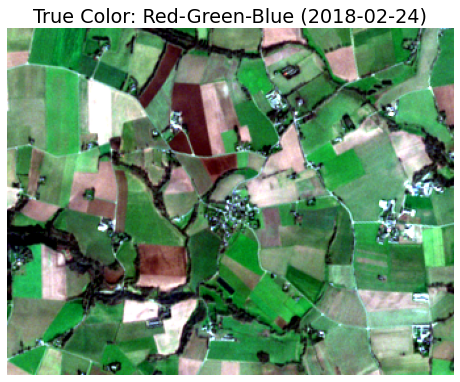

In [12]:
# optical satellite data measures reflectance (0-100%; unitless)
# for plotting, we need to rescale it to a value range for our perception
# here we use a normalization based on percentile as it is performed in QGIS for example 

# please change index
timeindex = 20

image = timeseries[timeindex]
date = dates[timeindex]

fig, ax = plt.subplots(figsize=(8,8))
rgb = np.nan_to_num(rgb_image).transpose(1,2,0)
ax.imshow((rgb-np.percentile(rgb, 2, axis=(0,1)))/(np.percentile(rgb, 98, axis=(0,1))-np.percentile(rgb, 2, axis=(0,1))))
ax.set_title(f"True Color: Red-Green-Blue ({date.strftime('%Y-%m-%d')})")
ax.axis("off")

### Explore the spectral dimension


#### 3-Band Composits

In [13]:
# interactive cells
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

timeindex = 20

@interact(bandred=bands, bandgreen=bands, bandblue=bands)
def plot_image(bandred="B4", bandgreen="B3", bandblue="B2"):
  fig, ax = plt.subplots(figsize=(8,8))
  rgb = np.nan_to_num(timeseries[timeindex, np.array([bands.index(b) for b in [bandred, bandgreen, bandblue]])]).transpose(1,2,0)
  ax.imshow((rgb-np.percentile(rgb, 2, axis=(0,1)))/(np.percentile(rgb, 98, axis=(0,1))-np.percentile(rgb, 2, axis=(0,1))))
  ax.set_title(f"bands: {bandred}-{bandgreen}-{bandblue}")
  ax.axis("off")

interactive(children=(Dropdown(description='bandred', index=3, options=('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B…

#### Spectral Indices

The normalized difference vegetation index

$NDVI = \frac{NIR-RED}{NIR+RED}$

measures the increase between red (absorbed due to chlorophyll) and near-infrared (scattered by leaf structure)

TODO: Context NDVI for vegetation applications



modified from [Wikipedia](https://link.springer.com/article/10.1007/s11676-020-01155-1)
<img src="https://breizhcrops.s3.eu-central-1.amazonaws.com/isprstutorial2022/Leaf_Tissue_Structure.png" width=600px>

figure from [Huang et al., 2021](https://link.springer.com/article/10.1007/s11676-020-01155-1)
<img src="https://breizhcrops.s3.eu-central-1.amazonaws.com/isprstutorial2022/huangetal2021_ndvi.png" width=400px>


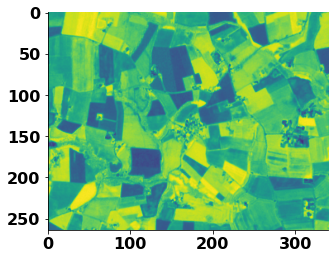

In [14]:
idx = 20

red = timeseries[idx, bands.index("B4")]
nir = timeseries[idx, bands.index("B8")]

ndvi = (nir-red)/(nir+red)

plt.imshow(ndvi)

### Explore the time dimension

<img src="https://breizhcrops.s3.eu-central-1.amazonaws.com/isprstutorial2022/Time.png" width=200px>

In [15]:
from skimage.exposure import equalize_hist

#@title
@interact(date=[d.strftime("%Y-%m-%d") for d in dates], show_rasterized_fields=False)
def plot_image(date="2018-03-26", show_rasterized_fields=False):

  # get index of the selected date
  idx = list(dates).index(datetime.strptime(date, "%Y-%m-%d"))
  
  # initialize figure
  fig, axs = plt.subplots(1,3,figsize=(6*3,6))

  # select the Red (B4) Green (B3) Blue (B2) bands
  ax = axs[0]
  rgb = np.nan_to_num(timeseries[idx, np.array([bands.index(b) for b in ["B4", "B3", "B2"]])])
  ax.imshow(equalize_hist(rgb).transpose(1,2,0))
  ax.set_title("True Color: Red-Green-Blue")


  if show_rasterized_fields:
    ax.imshow(croptype_rasterized, cmap=cmap)

  ax.axis("off")

  # select the NIR (B8) Red (B4) Green (B3) bands
  ax = axs[1]
  rgb = np.nan_to_num(timeseries[idx, np.array([bands.index(b) for b in ["B8", "B4", "B3"]])])
  ax.set_title("False Color: NIR-Red-Green")
  ax.imshow(equalize_hist(rgb).transpose(1,2,0))

  if show_rasterized_fields:
    ax.imshow(croptype_rasterized, cmap=cmap)

  ax.axis("off")

  # Calculate NDVI and plot
  ax = axs[2]
  ax.set_title("Norm. Diff. Vegetation Index (NDVI)")
  nir, red = np.nan_to_num(timeseries[idx, np.array([bands.index(b) for b in ["B8", "B4"]])])
  ndvi = (nir - red) / (nir + red)
  ndvi_img = ax.imshow(ndvi, vmin=0, vmax=1)
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  plt.colorbar(ndvi_img, cax=cax)
  cax.set_ylabel("NDVI")
  ax.axis("off")

  if show_rasterized_fields:
    ax.imshow(croptype_rasterized, cmap=cmap)

interactive(children=(Dropdown(description='date', index=31, options=('2018-01-02', '2018-01-05', '2018-01-07'…

# 3 Data Preprocessing

Early Sentinel 2 images have a quality flag `QA60`. values > 0 indicate cloud free observations.
Later Sentinel-2 scenes have a `MSK_CLDPRB` flag.

## Time series extraction of a single field

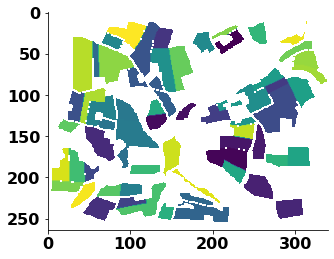

In [16]:
plt.figure()
plt.imshow(id_rasterized)

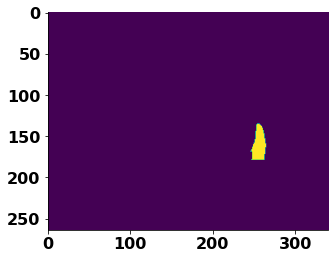

In [17]:
field_id = 5 # field id; try also 0,1,2,3,4
msk = id_rasterized==field_id
plt.figure()
plt.imshow(msk)

Raw sentinel-2 time series

Text(0, 0.5, 'reflectance')

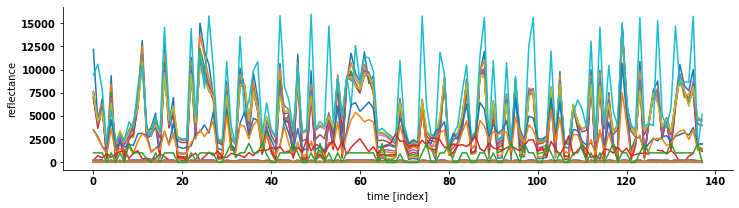

In [ ]:
average_band_values = timeseries[:,:,msk].mean(-1)

plt.figure(figsize=(12,3))
plt.plot(average_band_values)
plt.xlabel("time [index]")
plt.ylabel("reflectance")

In [18]:
#@title
reflectance_bands = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12"]
band_idxs = np.array([bands.index(b) for b in reflectance_bands])

@interact(field_id=gdf.ID.values, date=[d.strftime("%Y-%m-%d") for d in dates])
def plot_field(field_id=27, date="2018-03-26"):

  idx = list(dates).index(datetime.strptime(date, "%Y-%m-%d"))

  classname = gdf.loc[gdf.ID == field_id].classname.values[0]

  fig, axs = plt.subplots(1,2,figsize=(8*2,8))

  # first row: images
  ax = axs[0]
  ax.set_title(f"selected {classname} field")
  im = ax.imshow(id_rasterized==field_id)
  ax.axis("off")

  ax = axs[1]
  ax.set_title(f"overlay of RGB at {date}")
  rgb = np.nan_to_num(timeseries[idx, np.array([bands.index(b) for b in ["B4", "B3", "B2"]])])
  ax.imshow(equalize_hist(rgb).transpose(1,2,0))
  im = ax.contour(id_rasterized==field_id)
  ax.axis("off")

  msk = id_rasterized==field_id
  average_band_values = timeseries[:,:,msk].mean(-1)
  averaged_time_series = average_band_values[:,band_idxs]

  nirred = np.nan_to_num(average_band_values[:, np.array([bands.index(b) for b in ["B8", "B4"]])])
  nir, red = nirred[:,0], nirred[:,1]
  ndvi = (nir - red) / (nir + red)

  # second row: time series plots
  fig, axs = plt.subplots(1,2,figsize=(8*2,3))

  ax = axs[0]
  ax.plot(dates, averaged_time_series * 1e-2)
  ticks = [datetime(year=2018, month=m, day=1) for m in [2,4,6,8,10,12]]
  ax.set_xticks(ticks)
  ax.set_xticklabels([t.strftime("%b") for t in ticks])
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='left')
  ax.axvline(dates[idx], linewidth=5, color="black")
  ax.set_ylabel("reflectance [0-100%]")

  ax = axs[1]
  ax.plot(dates, ndvi)
  ticks = [datetime(year=2018, month=m, day=1) for m in [2,4,6,8,10,12]]
  ax.set_xticks(ticks)
  ax.set_xticklabels([t.strftime("%b") for t in ticks])
  ax.set_ylabel("ndvi [0-1]")
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='left')
  ax.axvline(dates[idx], linewidth=5, color="black")



interactive(children=(Dropdown(description='field_id', index=27, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11…

## Visual exploration of crop classes

In [19]:
#@title
reflectance_bands = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12"]
band_idxs = np.array([bands.index(b) for b in reflectance_bands])

@interact(classname1=gdf.classname.unique(), classname2=gdf.classname.unique(), date=[d.strftime("%Y-%m-%d") for d in dates])
def plot_class(classname1="wheat", classname2="corn", date="2018-03-26"):

  classid1 = gdf.loc[gdf.classname == classname1].iloc[0].id
  classid2 = gdf.loc[gdf.classname == classname2].iloc[0].id

  idx = list(dates).index(datetime.strptime(date, "%Y-%m-%d"))

  msk1 = croptype_rasterized==classid1
  msk2 = croptype_rasterized==classid2

  color1 = colors.loc[colors.classname==classname1].color.values[0]
  color2 = colors.loc[colors.classname==classname2].color.values[0]

  fig, axs = plt.subplots(2,1,figsize=(6,8), gridspec_kw={'height_ratios': [3,1]})

  ax = axs[0]
  ax.set_title(f"overlay of RGB at {date}")
  rgb = np.nan_to_num(timeseries[idx, np.array([bands.index(b) for b in ["B4", "B3", "B2"]])])
  ax.imshow(equalize_hist(rgb).transpose(1,2,0))
  im = ax.contour(msk1, colors=color1)
  im = ax.contour(msk2, colors=color2)
  ax.axis("off")

  IDS1 = gdf.loc[gdf.classname==classname1].ID.values
  IDS2 = gdf.loc[gdf.classname==classname2].ID.values

  def get_ndvi(IDS):
    ndvis = []
    for ID in IDS:
      msk = id_rasterized==ID
      average_band_values = timeseries[:,:,msk].mean(-1)
      averaged_time_series = average_band_values[:,band_idxs]

      nirred = np.nan_to_num(average_band_values[:, np.array([bands.index(b) for b in ["B8", "B4"]])])
      nir, red = nirred[:,0], nirred[:,1]
      ndvis.append((nir - red) / (nir + red))
    return np.stack(ndvis)

  ndvis1 = get_ndvi(IDS1)
  ndvis2 = get_ndvi(IDS2)

  ndvi_mean = ndvis1.mean(0)

  ax = axs[1]
  ax.fill_between(dates, ndvis1.mean(0) + ndvis1.std(0), ndvis1.mean(0) - ndvis1.std(0), color=color1, alpha=0.5)
  ax.plot(dates, ndvis1.mean(0), color=color1)

  ax.fill_between(dates, ndvis2.mean(0) + ndvis2.std(0), ndvis2.mean(0) - ndvis2.std(0), color=color2, alpha=0.5)
  ax.plot(dates, ndvis2.mean(0), color=color2)

  ticks = [datetime(year=2018, month=m, day=1) for m in [2,4,6,8,10,12]]
  ax.set_xticks(ticks)
  ax.set_xticklabels([t.strftime("%b") for t in ticks])
  ax.set_ylabel("ndvi [0-1]")
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='left')
  ax.axvline(dates[idx], linewidth=3)
  ax.legend([classname1, classname2], ncol=2, bbox_to_anchor=(0.65, 1.05))


interactive(children=(Dropdown(description='classname1', options=('wheat', 'corn', 'barley', 'rapeseed', 'temp…

## Cloud Filtering

Text(0.5, 1.0, 'Cloudyness by QA60 flag < 100: 27% are cloud free')

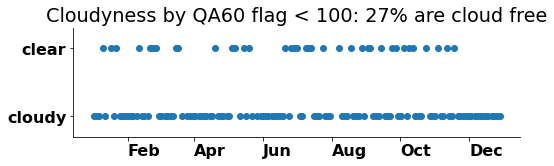

In [20]:
cloud_threshold = 100

cloudfreemask = timeseries[:,bands.index("QA60")].mean(1).mean(1) < cloud_threshold
filtered_timeseries = timeseries[cloudfreemask]
filtered_dates = list(np.array(dates)[cloudfreemask])

fig, ax = plt.subplots(1,1, figsize=(8,2))
ax.scatter(dates, cloudfreemask)
#ax.bar(dates, cloudmask, width=5)
ticks = [datetime(year=2018, month=m, day=1) for m in [2,4,6,8,10,12]]
ax.set_xticks(ticks)
ax.set_xticklabels([t.strftime("%b") for t in ticks])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='left')
ax.set_yticks([0,1])
ax.set_yticklabels(["cloudy","clear"])
ax.set_ylim(-.3,1.3)
ax.set_title(f"Cloudyness by QA60 flag < {cloud_threshold}: {cloudfreemask.mean()*100:.0f}% are cloud free")

In [21]:
#@title
reflectance_bands = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12"]
band_idxs = np.array([bands.index(b) for b in reflectance_bands])

@interact(classname1=gdf.classname.unique(), classname2=gdf.classname.unique(), date=[d.strftime("%Y-%m-%d") for d in filtered_dates])
def plot_class(classname1="wheat", classname2="corn", date="2018-06-21"):

  classid1 = gdf.loc[gdf.classname == classname1].iloc[0].id
  classid2 = gdf.loc[gdf.classname == classname2].iloc[0].id

  idx = filtered_dates.index(datetime.strptime(date, "%Y-%m-%d"))

  msk1 = croptype_rasterized==classid1
  msk2 = croptype_rasterized==classid2

  color1 = colors.loc[colors.classname==classname1].color.values[0]
  color2 = colors.loc[colors.classname==classname2].color.values[0]

  fig, axs = plt.subplots(2,1,figsize=(8,6), gridspec_kw={'height_ratios': [3,1]})

  ax = axs[0]
  ax.set_title(f"overlay of RGB at {date}")
  rgb = np.nan_to_num(filtered_timeseries[idx, np.array([bands.index(b) for b in ["B4", "B3", "B2"]])])
  ax.imshow(equalize_hist(rgb).transpose(1,2,0))
  im = ax.contour(msk1, colors=color1)
  im = ax.contour(msk2, colors=color2)
  ax.axis("off")

  IDS1 = gdf.loc[gdf.classname==classname1].ID.values
  IDS2 = gdf.loc[gdf.classname==classname2].ID.values

  def get_ndvi(IDS):
    ndvis = []
    for ID in IDS:
      msk = id_rasterized==ID
      average_band_values = filtered_timeseries[:,:,msk].mean(-1)
      averaged_time_series = average_band_values[:,band_idxs]

      nirred = np.nan_to_num(average_band_values[:, np.array([bands.index(b) for b in ["B8", "B4"]])])
      nir, red = nirred[:,0], nirred[:,1]
      ndvis.append((nir - red) / (nir + red))
    return np.stack(ndvis)

  ndvis1 = get_ndvi(IDS1)
  ndvis2 = get_ndvi(IDS2)

  ndvi_mean = ndvis1.mean(0)

  ax = axs[1]
  ax.fill_between(filtered_dates, ndvis1.mean(0) + ndvis1.std(0), ndvis1.mean(0) - ndvis1.std(0), color=color1, alpha=0.5)
  ax.plot(filtered_dates, ndvis1.mean(0), color=color1)

  ax.fill_between(filtered_dates, ndvis2.mean(0) + ndvis2.std(0), ndvis2.mean(0) - ndvis2.std(0), color=color2, alpha=0.5)
  ax.plot(filtered_dates, ndvis2.mean(0), color=color2)

  ticks = [datetime(year=2018, month=m, day=1) for m in [2,4,6,8,10,12]]
  ax.set_xticks(ticks)
  ax.set_xticklabels([t.strftime("%b") for t in ticks])
  ax.set_ylabel("ndvi [0-1]")
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='left')
  ax.axvline(filtered_dates[idx], linewidth=3)
  ax.legend([classname1, classname2], ncol=2, bbox_to_anchor=(0.65, 1.05))


interactive(children=(Dropdown(description='classname1', options=('wheat', 'corn', 'barley', 'rapeseed', 'temp…

# 4 Feature Design


## Calculate NDVI per field

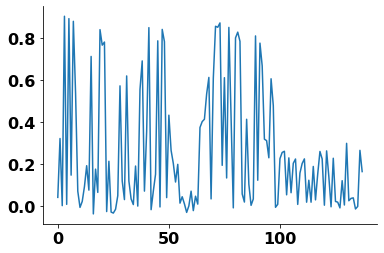

In [22]:
def get_ndvi_timeseries(field_ids, timeseries):
    """"""
    ndvis = []
    for ID in field_ids:
      msk = id_rasterized==ID
      average_band_values = timeseries[:,:,msk].mean(-1)
      averaged_time_series = average_band_values[:,band_idxs]

      nirred = np.nan_to_num(average_band_values[:, np.array([bands.index(b) for b in ["B8", "B4"]])])
      nir, red = nirred[:,0], nirred[:,1]
      ndvis.append((nir - red) / (nir + red))
    return np.stack(ndvis)

field_id = 30
ndvi_timeseries_single_field = get_ndvi_timeseries([field_id], timeseries)
plt.plot(ndvi_timeseries_single_field.T)

In [23]:
#@title

@interact(field_id=gdf.ID.values, cloud_filtered=False)
def plot_single_field_ndvi(field_id, cloud_filtered=False):

  ts = filtered_timeseries if cloud_filtered else timeseries

  ndvi_single_field = get_ndvi_timeseries([field_id], ts)
  fig, ax = plt.subplots()
  ax.plot(ndvi_single_field.T)
  ax.set_title(f"class: {gdf.loc[gdf.ID == field_id].classname.values[0]}")

  ax.set_xlabel("time [index]")
  ax.set_ylabel("ndvi")
  

interactive(children=(Dropdown(description='field_id', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, …

## Define a set of features

1) Maximum NDVI (blue)

2) Mean NDVI (red)

3) Day of the maximum NDVI (black)

4) Area under the NDVI curve (light blue)



In [24]:
features = ["max_ndvi", "mean_ndvi", "day_of_year_max_ndvi", "ndvi_area"]

In [25]:
def feature_extraction(ndvi_timeseries):

  # calculate mean NDVI
  mean_ndvi = ndvi_timeseries.mean(1)
  
  # calculate max NDVI
  max_ndvi = ndvi_timeseries.max(1)
  
  # calculate day of max NDVI [index]
  argmax_ndvi = ndvi_timeseries.argmax(1)

  # convert argmax to day of year
  day_of_year_max_ndvi = [d.timetuple().tm_yday for d in np.array(filtered_dates)[argmax_ndvi]]

  # calculate area under the NDVI curve
  doys = [d.timetuple().tm_yday for d in np.array(filtered_dates)]
  ndvi_area = np.trapz(ndvi_timeseries, doys)
  return max_ndvi, mean_ndvi, day_of_year_max_ndvi, ndvi_area, doys


In [26]:
color = "#ff0000"

@interact(field_id=gdf.ID.values)
def plot_features(field_id=27):

  # feature extraction
  ndvi_timeseries_single_field = get_ndvi_timeseries([field_id], filtered_timeseries)
  max_ndvi, mean_ndvi, day_of_year_max_ndvi, ndvi_area, doys = feature_extraction(ndvi_timeseries_single_field)

  # plotting
  fig, ax = plt.subplots()
  ax.plot(ndvi_timeseries_single_field[0])
  ax.fill_between(np.arange(len(ndvi_timeseries_single_field.T)), ndvi_timeseries_single_field[0], alpha=0.2)
  ax.axhline(mean_ndvi, color="red")
  ax.axhline(max_ndvi, color="blue")
  ax.axvline(list(doys).index(day_of_year_max_ndvi[0]), color="black")
  ax.set_title(f"area {ndvi_area[0]:.0f}")

  print(f"mean ndvi {mean_ndvi[0]:.2f}; day of max ndvi {day_of_year_max_ndvi[0]}; ndvi area {ndvi_area[0]:.2f}")


interactive(children=(Dropdown(description='field_id', index=27, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11…

In [27]:
ndvi_timeseries_all_fields = get_ndvi_timeseries(gdf.ID.values, filtered_timeseries)
max_ndvi, mean_ndvi, day_of_year_max_ndvi, ndvi_area, doys = feature_extraction(ndvi_timeseries_all_fields)

# add features to geodataframe
gdf["max_ndvi"] = max_ndvi
gdf["mean_ndvi"] = mean_ndvi
gdf["day_of_year_max_ndvi"] = day_of_year_max_ndvi
gdf["ndvi_area"] = ndvi_area

gdf.head()

,ID_PARCEL,SURF_PARC,CODE_CULTU,CODE_GROUP,CULTURE_D1,CULTURE_D2,geometry,id,classname,code,color,ID,max_ndvi,mean_ndvi,day_of_year_max_ndvi,ndvi_area
0,6025182,4.81,BTH,1,DVN,DVS,"POLYGON ((-2.91859 47.98955, -2.91890 47.98980...",1,wheat,BTH,#e41a1c,0,0.898532,0.547452,140,175.447427
1,6097821,9.82,BTH,1,DPH,DRD,"POLYGON ((-2.91462 47.97637, -2.91542 47.97662...",1,wheat,BTH,#e41a1c,1,0.877311,0.464679,140,158.440629
2,6097827,4.15,BTH,1,DPH,DRD,"POLYGON ((-2.93001 47.98207, -2.92670 47.98235...",1,wheat,BTH,#e41a1c,2,0.869162,0.468409,322,157.752491
3,6097919,3.00,BTH,1,DPH,DRD,"POLYGON ((-2.92173 47.98304, -2.92224 47.98292...",1,wheat,BTH,#e41a1c,3,0.871239,0.507909,140,164.763457
4,5980906,5.86,BTH,1,DRD,DMD,"POLYGON ((-2.91668 47.97996, -2.91649 47.97996...",1,wheat,BTH,#e41a1c,4,0.881536,0.479094,140,163.978417


(0.0, 1.0, 0.0, 1.0)

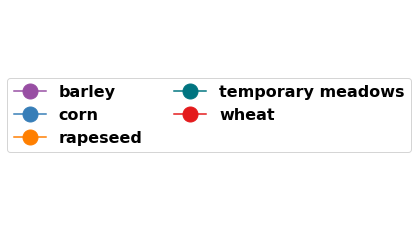

In [28]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color=color, label=name,
                          markerfacecolor=color, markersize=15) for 
                   name,color in gdf.groupby("classname").first()["color"].items()]

# Create the figure
fig, ax = plt.subplots()
ax.legend(handles=legend_elements, loc='center', ncol=2)
ax.axis("off")

In [29]:
feature1 = "max_ndvi"
feature2 = "mean_ndvi"

@interact(feature1=features, feature2=features)
def plot_features(feature1="mean_ndvi", feature2="max_ndvi"):
  fig, ax = plt.subplots()
  scatter = ax.scatter(gdf[feature1], gdf[feature2], c=gdf.color, s=200)
  ax.set_xlabel(feature1.replace("_"," "))
  ax.set_ylabel(feature2.replace("_"," "))

interactive(children=(Dropdown(description='feature1', index=1, options=('max_ndvi', 'mean_ndvi', 'day_of_year…

# 5 Classification

A simple classificaiton pipeline. More in the next notebook

In [30]:
# machine learning
import sklearn.svm
from skimage.exposure import equalize_hist
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


## Train-Test Split

In [31]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(gdf, test_size=0.5,random_state=0)

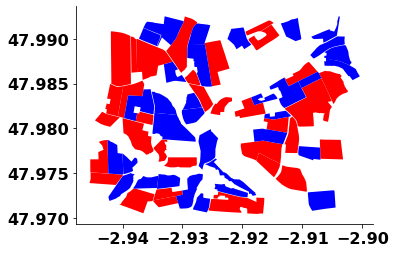

In [32]:
fig, ax = plt.subplots()
train.plot(ax=ax, color="red")
test.plot(ax=ax, color="blue")

## Support Vector Machine

In [33]:

X = train[features].values
y = train["id"]

svm = sklearn.svm.SVC(C=3)
svm.fit(X,y)

X_test = test[features].values
y_test = test["id"]

y_pred = svm.predict(X_test)

print(classification_report(y_true=y_test, y_pred=y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.33      0.50      0.40         6
           2       0.00      0.00      0.00         1
           3       0.79      0.95      0.86        20
           8       0.00      0.00      0.00         4

    accuracy                           0.67        33
   macro avg       0.23      0.29      0.25        33
weighted avg       0.54      0.67      0.60        33



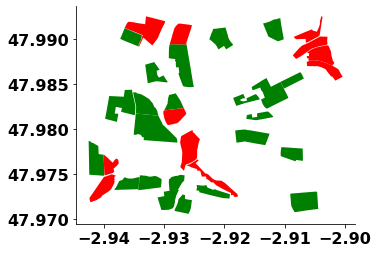

In [34]:
test["y_pred"] = y_pred
test["correct"] = test.id == y_pred

fig, ax = plt.subplots()
test.loc[test.correct].plot(color="green", ax=ax)
test.loc[~test.correct].plot(color="red", ax=ax)


# Conclusions

## Summary: 

We went through the feature engineering pipeline

Raw Sentinel-2 time series $\rightarrow$ field extraction and NDVI calculation $\rightarrow$ cloud filtering $\rightarrow$ feature design $\rightarrow$ classification

and gained an understanding of the data (Sentinel-2 time series) and problem (crop type classification)


## How to improve?

some ideas:

* Define better features:

e.g. Fit curves to NDVI profiles, as in [TimeSat](https://web.nateko.lu.se/timesat/timesat.asp)

<img src="https://web.nateko.lu.se/timesat/images/TIMESAT_parameters.png" width=400px>

* improve the preprocessing

better cloud mask? E.g. S2cloudless, or `CLD_PRB` band

* tune the classifier

Support vector machine? Random Forest? Gradient Boosting?

* handle the label imbalance

add more loss weight on infrequent samples?

## Next steps


End-to-end feature learning in [the next notebook](https://colab.research.google.com/drive/1DYZGgFfIA92gb7SaVi2ZPgmcIAc101rl?usp=sharing)

see also the [Tutorial website](https://dl4sits.github.io/isprs2022/tutorial/)